In [1]:
'''
In this notebook, we generate features using 2 algorithsm, KAZE and ORB
'''

'\nIn this notebook, we generate features using 2 algorithsm, KAZE and ORB\n'

In [3]:
#for array manipulations
import numpy as np
#for image processing
import cv2 
#for displaying images
import matplotlib.pyplot as plt
#to display images in this notebook, not in a separate window
%matplotlib inline
#to access system resources such as directories
import os

In [8]:
#Set this to point to the project root; all paths will be relative to this one
project_dir = '/home/lyle/notebooks/maize-disease-detection/'

In [9]:
def set_up_directories(project_dir=project_dir):
    """Sets up the paths to important direcoties
    
    Parameters
    ----------
    project_dir : string; default is the current working directory
        The path to the project root i.e '/home/lyle/tutorials/AI/scikit-learn/maize-disease-detection/'
    
    returns
    -------
    base_dir : string
        The project directory path
    data_folder : string
        The data subfolder path
    maize_data_folder : 
        The path to the subdirectory containing the maize images
        
    example usage
    -------------
    base_dir, data_folder, maize_data_folder = set_up_directories()
    """
    
    #set our base directory. This should point to the location of the plant-diseases folder
    base_dir = project_dir
    #set the path to our data folder
    data_folder = os.path.join(base_dir, 'data')
    #set the path to the maize folder and list the various categories available
    maize_data_folder = os.path.join(data_folder, 'maize')

    return base_dir, data_folder, maize_data_folder

def get_32(disease):
    """Loads 32 images for a given maize disease
    
    parameters
    ----------
    disease: string
        A string that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    returns
    -------
    disease_images: list
        A list of images for the selected disease
    """
    
    #this list will contain the 20 images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(maize_data_folder, disease)
    for image_path in os.listdir(disease_images_path):
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
    return disease_images

#This function will help us plot 10 images
def plot_images(images, title):
    """Plots 10 images of a particular disease category
    
    parameters
    ----------
    images: list
        List of images(each image is an array)
    title: string
        Title for each image i.e name of disease
    """
    
    plt.figure(figsize=(12,8))
    for i in range(10):
        plt.subplot(2,5, i+1)
        plt.imshow(images[i])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
#This function allows us to resize images
def resize(image, new_size=(600,600)):
    """Resize the given image
    
    parameters
    ----------
    image : numpy array
        The image to be resized
    new_size : tuple
        The new image size
    returns
    -------
    resized_image : numpy arra
        The resized image
    """
    
    resized_image = cv2.resize(image, new_size)
    return resized_image

In [10]:
#Directories set up
base_dir, data_folder, maize_data_folder = set_up_directories()

In [11]:
common_rust_images = get_32('common_rust')
healthy_images = get_32('healthy')
leaf_spot_images = get_32('leaf_spot')
nothern_leaf_blight_images = get_32('nothern_leaf_blight')

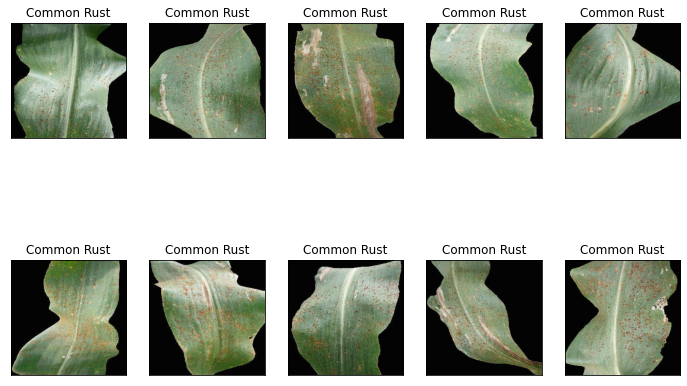

In [12]:
plot_images(common_rust_images[:10], 'Common Rust')

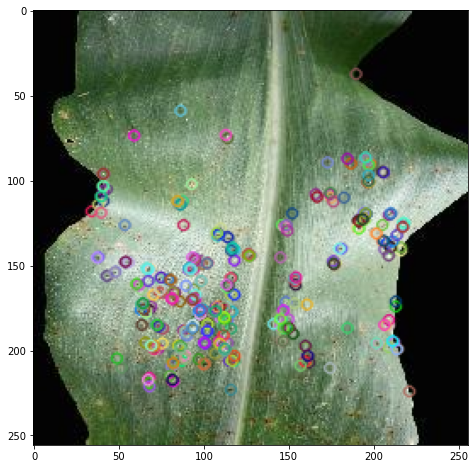

In [13]:
#We will use ORB to gnerate features
orb = cv2.ORB_create()
kps, ds = orb.detectAndCompute(common_rust_images[0], None)
with_keypoints = cv2.drawKeypoints(common_rust_images[0], kps, None)
plt.figure(figsize=(12,8))
plt.imshow(with_keypoints)

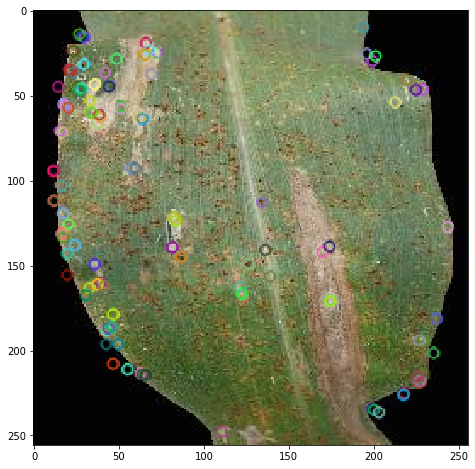

In [14]:
#We will use KAZE to gnerate features
kaze = cv2.KAZE_create()
kps, ds = kaze.detectAndCompute(common_rust_images[0], None)
with_keypoints = cv2.drawKeypoints(common_rust_images[0], kps, None)
plt.figure(figsize=(12,8))
plt.imshow(with_keypoints)

In [16]:
#We will use hog to generate features
winSize = (20,20)
blockSize = (16,16)
blockStride = (4,4)
cellSize = (16,16)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)
image = resize(common_rust_images[0], (100,100))
features = hog.compute(image)
print(f'The HOG features calculated are {features.shape}')

The HOG features calculated are (1296, 1)


In [25]:
#This function generates ORB features
def extract_features_orb(image, vector_size=32):
    """Extracts orb features for the given image
    
    parameters
    ----------
    image : numpy array
        The image whose features are to be extracted
    vector_size : int
        The number of keypoints to use
    returns
    -------
        orb_decriptors : 
        
    raises
    ------
    cv2.error
    """
    try:
        feature_generator = cv2.ORB_create()
        orb_keypoints = feature_generator.detect(image)
        orb_keypoints = orb_keypoints[:32]
        orb_keypoints, orb_descriptors = feature_generator.compute(image, orb_keypoints)
        orb_descriptors = orb_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if orb_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            orb_descriptors = np.concatenate([orb_descriptors, np.zeros(needed_size - orb_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return orb_descriptors

#This function generates KAZE features
def extract_features_kaze(image, vector_size=32):
    """Extracts kaze features for the given image
    
    parameters
    ----------
    image : numpy array
        The image whose features are to be extracted
    vector_size : int
        The number of keypoints to use
    returns
    -------
        kaze_descriptors : 
        
    raises
    ------
    cv2.error
    """
    try:
        feature_generator = cv2.KAZE_create()
        kaze_keypoints = feature_generator.detect(image)
        kaze_keypoints = kaze_keypoints[:32]
        kaze_keypoints, kaze_descriptors = feature_generator.compute(image, kaze_keypoints)
        kaze_descriptors = kaze_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if kaze_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            kaze_descriptors = np.concatenate([kaze_descriptors, np.zeros(needed_size - kaze_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return kaze_descriptors

def get_hog(): 
    """Creates the hog operator
    
    returns
    -------
    hog:
    """
    winSize = (20,20)
    blockSize = (16,16)
    blockStride = (4,4)
    cellSize = (16,16)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog

def extract_hog_features(image, feature_size=4096):
    """Extracts hog features for the image
    
    parameters
    ----------
    image : numpy array
        The image whose features are to be extracted
    feature_size : int
        The number of features to generate
    returns
    -------
        hog_features : numpy array 
        
    raises
    ------
    cv2.error
    """
    hog = get_hog()
    features = hog.compute(image)
    required_features = features[:feature_size].ravel()
    return required_features 

In [27]:
common_rust_image_orb_features = extract_features_orb(common_rust_images[0])
common_rust_image_kaze_features = extract_features_kaze(common_rust_images[0])
common_rust_image_hog_features = extract_hog_features(common_rust_images[0])
(common_rust_image_orb_features.shape, common_rust_image_kaze_features.shape, 
common_rust_image_hog_features.shape)

((4096,), (4096,), (4096,))

In [28]:
healthy_image_orb_features = extract_features_orb(healthy_images[0])
healthy_image_kaze_features = extract_features_kaze(healthy_images[0])
healthy_image_hog_features = extract_hog_features(healthy_images[0])
(healthy_image_orb_features.shape, healthy_image_kaze_features.shape,
 healthy_image_hog_features.shape)

((4096,), (4096,), (4096,))

In [29]:
leaf_spot_image_orb_features = extract_features_orb(leaf_spot_images[0])
leaf_spot_image_kaze_features = extract_features_kaze(leaf_spot_images[0])
leaf_spot_image_hog_features = extract_hog_features(leaf_spot_images[0])
(leaf_spot_image_orb_features.shape, leaf_spot_image_kaze_features.shape,
 leaf_spot_image_hog_features.shape)

((4096,), (4096,), (4096,))

In [30]:
nothern_leaf_blight_image_orb_features = extract_features_orb(nothern_leaf_blight_images[0])
nothern_leaf_blight_image_kaze_features = extract_features_kaze(nothern_leaf_blight_images[0])
nothern_leaf_blight_image_hog_features = extract_hog_features(nothern_leaf_blight_images[0])
(nothern_leaf_blight_image_orb_features.shape, nothern_leaf_blight_image_kaze_features.shape,
 nothern_leaf_blight_image_hog_features.shape)

((4096,), (4096,), (4096,))